# Part 2 - Exploratory Data Analytics

Using the output from Part 1. 

The goal of this workbook is to explore the dataset and find answers to the below:

1. Average number of accidents by month by borough
2. What are the most dangerous hours of the day for pedestrians?
3. Year with most accidents?
4. Visualize data
5. Any other insights we find, data quality

I have also created a Tableau workbook to visualize the data. I use Tableau to plot the geolocation information, which also makes it handy to see if there are DQ issues with the data as-is. An alternative solution would be to download ShapeFiles from NYC OpenData and to plot the latitude and longitude coordinates using the `shapefile` library in python. The link to Tableau Workbook can be found [Tableau Online Dashboard - NYC OpenData](https://public.tableau.com/app/profile/jordan.carson/viz/NYCOpenData/NYCOpenData?publish=yes).

In [111]:
import os
import sys
import pickle
from pathlib import Path
CWD = str(Path.cwd().parent)
sys.path.append(CWD)
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # dataframes
import random # gather a random list of ints
random.seed(18)
import pgeocode, geopy # geo lib
import datatable as dt
geo = pgeocode.Nominatim(country='us')
from datatable import f, by
# personal common lib
from common.utilities import decorators 
from src.api.zip_codes import get_zip_codes
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
print(CWD)

/Users/jordancarson/Projects/JPM/data-engineering-nyc


We are going to be using both `pandas` for our EDA (exploratory data analysis). The below data has not been transformed from source and is in the same shape and size as the entire NYC OpenData MVCC table. We have parameters within pd.read_csv but we need to be careful.

In [94]:
collision_df = pd.read_csv(
    os.path.join(CWD, '.data', 'output.csv'),
    # parse_dates={'crash_date_time': ["crash_date", "crash_time"]},
    # infer_datetime_format=True,
    dtype={'zip_code': "str"}
)

In [12]:
collision_df.shape

(1830092, 30)

We have 1,830,092 rows, with 29 columns. A [data dictionary](https://data.cityofnewyork.us/api/views/h9gi-nx95/files/bd7ab0b2-d48c-48c4-a0a5-590d31a3e120?download=true&filename=MVCollisionsDataDictionary_20190813_ERD.xlsx) is available which shows the metadata and table relationship between the Motor Vehicle - Crashes, Vehicles and Persons.

In [13]:
collision_df.head(5)

,Unnamed: 0,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,...,collision_id,vehicle_type_code1,vehicle_type_code2,contributing_factor_vehicle_3,vehicle_type_code_3,cross_street_name,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_4,vehicle_type_code_5
0,0,2012-07-01T00:00:00.000,2021-10-15 10:40:00,MANHATTAN,10013.0,40.720854,-74.003929,"{'latitude': '40.7208537', 'longitude': '-74.0...",CANAL STREET,WOOSTER STREET,...,22,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2012-07-01T00:00:00.000,2021-10-15 12:18:00,MANHATTAN,10004.0,40.704799,-74.016685,"{'latitude': '40.7047985', 'longitude': '-74.0...",BATTERY PLACE,WEST STREET,...,23,TAXI,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012-07-01T00:00:00.000,2021-10-15 15:00:00,NaN,NaN,NaN,NaN,NaN,WATER STREET,OLD SLIP,...,24,BUS,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2012-07-01T00:00:00.000,2021-10-15 18:00:00,MANHATTAN,10007.0,40.713692,-74.013754,"{'latitude': '40.7136919', 'longitude': '-74.0...",WEST STREET,VESEY STREET,...,25,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-07-01T00:00:00.000,2021-10-15 19:30:00,MANHATTAN,10013.0,40.719058,-74.012442,"{'latitude': '40.719058', 'longitude': '-74.01...",WEST STREET,HARRISON STREET,...,26,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
collision_df['crash_date'].min(), collision_df['crash_date'].max()

('2012-07-01T00:00:00.000', '2021-10-11T00:00:00.000')

The Collision Data **begins** on ***July 1st 2012*** and series **ends** on ***October 11th 2021***. 

## Adding Features

If we want to find the answers to some of Michael's questions we first need to include additional features in our result-set. Creating time specific fields, to pivot by later.

In [95]:
collision_df['crash_date'] = pd.to_datetime(collision_df['crash_date'], format="%Y-%m-%d")
collision_df['crash_time'] = collision_df['crash_time'].str[11:] # slicing to get only the time value back
collision_df['year'] = collision_df['crash_date'].dt.year
collision_df['month'] = collision_df['crash_date'].dt.month
collision_df['day'] = collision_df['crash_date'].dt.day
collision_df['hour'] = collision_df['crash_time'].str[:2]
collision_df['minutes'] = collision_df['crash_time'].str[3:5]
collision_df['seconds'] = collision_df['crash_time'].str[6:]
collision_df['day_of_week'] = collision_df['crash_date'].dt.weekday
collision_df['incidents'] = 1

In [106]:
# Create a time of day field, representing Night, Morning, Afternoon and Evening
def time_of_day(hour):
    # create a vectorized function to calculate time of day
    if hour <= 0 and hour >= 5:
        return 'Night'
    elif hour > 5 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour <= 17:
        return 'Afternoon'
    elif hour > 17 and hour <=20:
        return 'Evening'
    else:
        return 'Night'

# ensure hour is casted to integer before calling the npVec function
np_vec_time_of_day = np.vectorize(time_of_day)

collision_df.loc[:, 'hour'] = collision_df.loc[:, 'hour'].astype(int)
collision_df.loc[:, 'time_of_day'] = np_vec_time_of_day(collision_df['hour'].values)

In [131]:
collision_df[['hour', 'time_of_day']][collision_df['hour'].isin(random.sample(range(24), 10))].head(12) # [x for x in range(0, 24) if x % 2==1]

,hour,time_of_day
2,15,Afternoon
4,19,Evening
10,13,Afternoon
12,11,Morning
18,17,Afternoon
19,17,Afternoon
23,19,Evening
24,9,Morning
25,9,Morning
27,13,Afternoon


We easily created a new field using np.vectorization. Then filtered the dataset for random integers from 0 to 24 to test our work. We did not return one row per the list of integers, rather we are showing only the top 12 records based on our filter criteria.

In [35]:
# what columns are available
collision_df.columns

Index(['Unnamed: 0', 'crash_date', 'crash_time', 'borough', 'zip_code',
       'latitude', 'longitude', 'location', 'on_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'collision_id', 'vehicle_type_code1',
       'vehicle_type_code2', 'contributing_factor_vehicle_3',
       'vehicle_type_code_3', 'cross_street_name',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'vehicle_type_code_4', 'vehicle_type_code_5', 'year', 'month', 'day',
       'hour', 'minutes', 'seconds', 'incidents', 'day_of_week'],
      dtype='object')

In [19]:
# Next find missing data
print(collision_df.shape[0] - collision_df.count())

Unnamed: 0                             0
crash_date                             0
crash_time                             0
borough                           564983
zip_code                          565203
latitude                          214300
longitude                         214300
location                          214300
on_street_name                    373516
off_street_name                   656307
number_of_persons_injured             18
number_of_persons_killed              31
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       5247
contributing_factor_vehicle_2     264256
collision_id                           0
vehicle_type_code1                  9986
vehicle_type_code2                313450
contributing_factor_vehicle_3    1705024
vehicle_type_cod

### Categorical Data Stats

In [33]:
collision_df.describe(include=['O'])

,crash_time,borough,zip_code,location,on_street_name,off_street_name,contributing_factor_vehicle_1,contributing_factor_vehicle_2,vehicle_type_code1,vehicle_type_code2,contributing_factor_vehicle_3,vehicle_type_code_3,cross_street_name,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_4,vehicle_type_code_5,hour,minutes,seconds
count,1830092,1265109,1264889,1615792,1456576,1173785,1824845,1565836,1820106,1516642,125068,121374,281147,27301,7226,26491,7028,1830092,1830092,1830092
unique,1440,5,420,262268,15765,19199,61,61,1291,1420,50,195,176645,39,29,82,55,24,60,1
top,16:00:00,BROOKLYN,11207.0,"{'latitude': '0.0', 'longitude': '0.0'}",BROADWAY,3 AVENUE,Unspecified,Unspecified,Sedan,Sedan,Unspecified,Sedan,772 EDGEWATER ROAD,Unspecified,Unspecified,Sedan,Sedan,16,00,00
freq,26162,398169,21026,1766,17278,9843,647943,1317547,462860,337411,116471,33958,402,25755,6810,7947,2197,134339,359486,1830092


Some fields do have many missing value. Date and time is always populated. There are 565,203 cases with no zip_code and 564,983 with no borough. Latitude and Longitude data has about 214,300 missing entries. Along with the location - location is a tuple of the lat/long data. We should be able to infer the zip-code and borough from the geolocation fields and or from additional sources.

From the dataset we can ask the following questions. 

1. Which borough has the most collisions? 
2. What is the biggest reason? 
3. Is there a particular zip code that has more collisions than others? 
4. What hour do most crashes occur? (One of Mike's q's) 
5. What day of week / weekday has the most collisions? 
6. What is the number 1 vehicle in colisions? From the above we can see Sedan tops the list in the vehicle_type_code1.
7. Which street in the West Village, has the most collisions?
8. Lastly, how many collisions for Cyclists where at least one person was injured or killed? Motorists?

In [20]:
# Which borough has the most collisions?
(collision_df
    .groupby('borough')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
)

,collision_id
borough,
BROOKLYN,398169
QUEENS,338807
MANHATTAN,291402
BRONX,183406
STATEN ISLAND,53325


Most accidents and collisions occur in Brooklyn and Queens. What are the biggest reasons for collisions in Brooklyn and Queens?

In [21]:
# What is the biggest reason for collisions?
(collision_df[collision_df['borough'].isin(['BROOKLYN', 'QUEENS'])]
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(15)
)

,collision_id
contributing_factor_vehicle_1,
Unspecified,297863
Driver Inattention/Distraction,135604
Failure to Yield Right-of-Way,53638
Backing Unsafely,33358
Following Too Closely,24053
Passing Too Closely,17878
Passing or Lane Usage Improper,16585
Other Vehicular,14369
Turning Improperly,14085


Most of the collisions are unspecified. In fact, this is the largest factor across all boroughs. See below.

In [26]:
# What is the biggest reason for collisions?
(collision_df
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
contributing_factor_vehicle_1,
Unspecified,647943
Driver Inattention/Distraction,354540
Failure to Yield Right-of-Way,105892
Following Too Closely,95262
Backing Unsafely,69258


In [27]:
# Which zipcodes have the largest collisions?
(collision_df
    .groupby('zip_code')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
zip_code,
11207.0,21026
11236.0,14981
11203.0,14258
11234.0,14100
10019.0,13835


In [38]:
# what is the location for the top five zip codes?
geo.query_postal_code('11207')#['county_name']
# nomi_zipcode_data

postal_code          11207
country_code            US
place_name        Brooklyn
state_name        New York
state_code              NY
county_name          Kings
county_code           47.0
community_name         NaN
community_code         NaN
latitude           40.6705
longitude          -73.894
accuracy               4.0
Name: 0, dtype: object

The location with the largest number of collisions, is Kings County in Brooklyn. `pgeocode` provides a very convenient interface to pull information from zip codes. We will talk about this more.

In [41]:
# Which street has the most collisions in my area?
(collision_df[collision_df['zip_code']=='10014.0']
    .groupby(['on_street_name', 'off_street_name'])
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,,collision_id
on_street_name,off_street_name,
VARICK STREET,WEST HOUSTON STREET,70
11 AVENUE,WEST 14 STREET,55
WEST STREET,WEST HOUSTON STREET,54
WEST HOUSTON STREET,VARICK STREET,52
VARICK STREET,CHARLTON STREET,50


In [42]:
# Which street has the most collisions in my area?
(collision_df[collision_df['zip_code']=='10014.0']
    .groupby('on_street_name')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
on_street_name,
WEST STREET,527
7 AVENUE SOUTH,399
VARICK STREET,337
HUDSON STREET,287
WEST HOUSTON STREET,218


It is interesting to see that in the West Village - West Street, Varick and West Houston Street have had the most collisions since July 2012. What about the number 1 vehicle?

In [48]:
# Which street has the most collisions in my area?
(collision_df[collision_df['zip_code']=='10014.0']
    .groupby('vehicle_type_code1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
vehicle_type_code1,
PASSENGER VEHICLE,975
Sedan,658
Station Wagon/Sport Utility Vehicle,557
TAXI,472
SPORT UTILITY / STATION WAGON,333


In the West Village, Passenger Vehicle, Segan and SUV are the top three types of vehicles in collisions.

[]

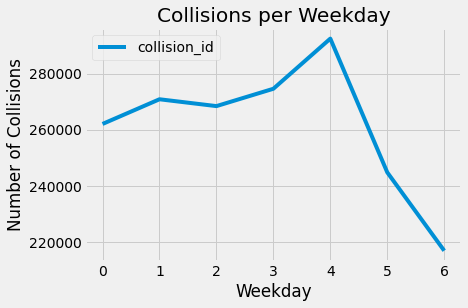

In [44]:
def plot_collisions_by_dow(data):
    data['day_of_week'] = data['day_of_week'].astype(int)
    p = data.groupby('day_of_week').agg({'collision_id': len}).sort_values(by='day_of_week', ascending=False)
    p.plot()
    plt.title('Collisions per Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Number of Collisions')
    return plt.plot()
plot_collisions_by_dow(collision_df)

The day_of_week variable holds data from 0-6, where 0 corresponds to Monday and 6 to Sunday. We can see most collisions occur on Friday. I decided to change the Day of Week values to integers, visualizing puts them in order.

In [92]:
collision_df['hour'].value_counts()

    1830092
Name: hour, dtype: int64

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_23301/1210963926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyclist_injured['hour'] = cyclist_injured['hour'].astype(int)


[]

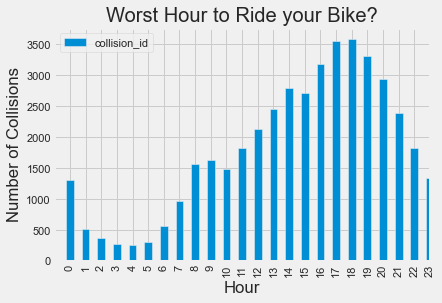

In [102]:
def plot_collisions_by_hour(data):
    cyclist_injured = data.query("number_of_cyclist_injured > 0 | number_of_cyclist_killed > 0")
    cyclist_injured['hour'] = cyclist_injured['hour'].astype(int)
    p = cyclist_injured.groupby('hour').agg({'collision_id': len}).sort_values(by='hour', ascending=False)
    p.plot(kind='bar')
    plt.title('Worst Hour to Ride your Bike?')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    plt.xlim(24, 0)
    return plt.plot()
plot_collisions_by_hour(collision_df)

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_23301/3320194960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injured['hour'] = injured['hour'].astype(int)


[]

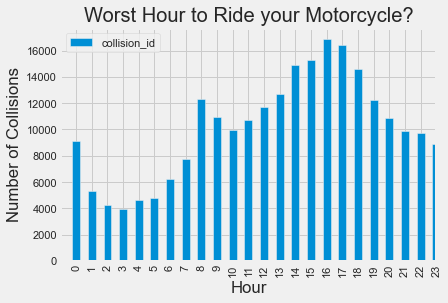

In [104]:
def plot_collisions_by_hour(data):
    injured = data.query("number_of_motorist_killed > 0 | number_of_motorist_injured > 0")
    injured['hour'] = injured['hour'].astype(int)
    p = injured.groupby('hour').agg({'collision_id': len}).sort_values(by='hour', ascending=False)
    p.plot(kind='bar')
    plt.title('Worst Hour to Ride your Motorcycle?')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    plt.xlim(24, 0)
    return plt.plot()
plot_collisions_by_hour(collision_df)

The worst hours to ride your bike and motorcycle are still during the morning hours and early afternoon. 

# Mike's Questions
## Question 1: What are the average number of accidents per month per borough

We summarize the collisions per year and divide the amount by **the number of months** to obtain an per month average by borough for the year. Given the start of the dataset in 2012 begins in July, we cannot simply divide all yearly values by 12. 

In [60]:
keep_cols = ['year', 'month', 'borough', 'collision_id']
question1 = collision_df[keep_cols].drop_duplicates()

# Next we count the number of collisions by year month and borough, we reset the index and rename the collision_id to nbr of collisions
question1 = question1.pivot_table(values='collision_id', index=['year', 'month', 'borough'], aggfunc=len).reset_index().rename({'collision_id': 'nbr_of_collisions'}, axis=1)

In [57]:
# We need to calculate the number of unique months by year - and add this as a column, below we are creating a pivot_table to view the data
question1.pivot_table(values='month', index='year', aggfunc=pd.Series.nunique)

,month
year,
2012,6
2013,12
2014,12
2015,12
2016,12
2017,12
2018,12
2019,12
2020,12


In [61]:
# we can do this in one line - we do not need to create a separate dataframe then join this to our question1 dataframe, below we properly count the number of months
question1.loc[:, 'nbr_of_months'] = (
    question1.groupby(['year'])['month'].transform('nunique')
)

In [62]:
# make sure we have the correct data
question1.head()

,year,month,borough,nbr_of_collisions,nbr_of_months
0,2012,7,BRONX,1641,6
1,2012,7,BROOKLYN,3886,6
2,2012,7,MANHATTAN,3654,6
3,2012,7,QUEENS,3204,6
4,2012,7,STATEN ISLAND,768,6


In [68]:
# next, we need to count the number of collisions by year and borough - also let's add the number of months as a column so we can easily divide the two
question1.loc[:, 'nbr_of_months'] = (
    question1.groupby(['year'])['month'].transform('nunique')
)
agg_question1 = question1.pivot_table(values='nbr_of_collisions', index=['year', 'borough', 'nbr_of_months'], aggfunc=np.sum).reset_index()
# visualize, the data looks like we are ready to apply our calculation
agg_question1

,year,borough,nbr_of_months,nbr_of_collisions
0,2012,BRONX,6,9511
1,2012,BROOKLYN,6,23305
2,2012,MANHATTAN,6,20721
3,2012,QUEENS,6,19138
4,2012,STATEN ISLAND,6,4902
5,2013,BRONX,12,19768
6,2013,BROOKLYN,12,47020
7,2013,MANHATTAN,12,41581
8,2013,QUEENS,12,39309
9,2013,STATEN ISLAND,12,8295


In [73]:
agg_question1.loc[:, 'average_collisions_per_month'] = agg_question1.loc[:, 'nbr_of_collisions'] / agg_question1.loc[:, 'nbr_of_months']
agg_question1


,year,borough,nbr_of_months,nbr_of_collisions,average_collisions_per_month
0,2012,BRONX,6,9511,1585.166667
1,2012,BROOKLYN,6,23305,3884.166667
2,2012,MANHATTAN,6,20721,3453.500000
3,2012,QUEENS,6,19138,3189.666667
4,2012,STATEN ISLAND,6,4902,817.000000
5,2013,BRONX,12,19768,1647.333333
6,2013,BROOKLYN,12,47020,3918.333333
7,2013,MANHATTAN,12,41581,3465.083333
8,2013,QUEENS,12,39309,3275.750000
9,2013,STATEN ISLAND,12,8295,691.250000


<AxesSubplot:xlabel='year', ylabel='average_collisions_per_month'>

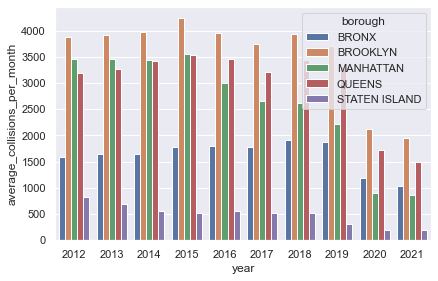

In [82]:
sns.barplot(x="year", y="average_collisions_per_month", data=agg_question1, hue='borough', estimator=sum)

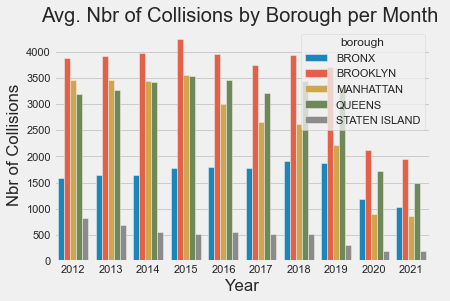

,year,borough,nbr_of_months,nbr_of_collisions,average_collisions_per_month
0,2012,BRONX,6,9511,1585.166667
1,2012,BROOKLYN,6,23305,3884.166667
2,2012,MANHATTAN,6,20721,3453.500000
3,2012,QUEENS,6,19138,3189.666667
4,2012,STATEN ISLAND,6,4902,817.000000
5,2013,BRONX,12,19768,1647.333333
6,2013,BROOKLYN,12,47020,3918.333333
7,2013,MANHATTAN,12,41581,3465.083333
8,2013,QUEENS,12,39309,3275.750000
9,2013,STATEN ISLAND,12,8295,691.250000


In [132]:
# finally, putting this all in a function

def calc_question1(data: pd.DataFrame):
    keep_cols = ['year', 'month', 'borough', 'collision_id']
    question1 = data[keep_cols].drop_duplicates()
    question1 = question1.pivot_table(values='collision_id', index=['year', 'month', 'borough'], aggfunc=len).reset_index().rename({'collision_id': 'nbr_of_collisions'}, axis=1)
    question1.loc[:, 'nbr_of_months'] = (
    question1.groupby(['year'])['month'].transform('nunique')
    )
    agg_question1 = question1.pivot_table(values='nbr_of_collisions', index=['year', 'borough', 'nbr_of_months'], aggfunc=np.sum).reset_index()
    agg_question1.loc[:, 'average_collisions_per_month'] = agg_question1.loc[:, 'nbr_of_collisions'] / agg_question1.loc[:, 'nbr_of_months']
    fig = sns.barplot(x="year", y="average_collisions_per_month", data=agg_question1, hue='borough', estimator=sum)
    plt.xlabel("Year")
    plt.ylabel("Nbr of Collisions")
    plt.title("Avg. Nbr of Collisions by Borough per Month ")
    plt.show(fig)
    return agg_question1
calc_question1(collision_df)

In 2015, Brooklyn sees the largest average number of collisions with 4237 1/4.\
The average amount visually appears to be steady for each borough until 2020. Due to Covid, less people going into the office, therefore less drivers on the road to potentially cause a collision.

## Question 2: Which hour of the day is the most dangerous for pedestrians?

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_15701/3379795862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)


[]

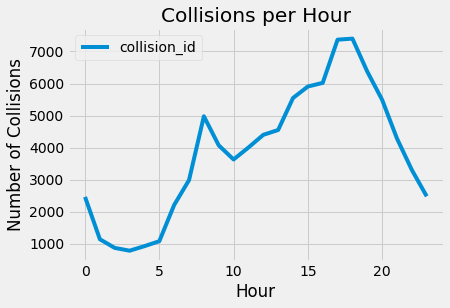

In [74]:
def plot_collisions_by_hour(data):
    pedestrians_injured = data.query("number_of_pedestrians_injured > 0 | number_of_pedestrians_killed > 0")
    pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)
    p = pedestrians_injured.groupby('hour').agg({'collision_id': len}).sort_values(by='hour', ascending=False)
    p.plot()
    plt.title('Collisions per Hour')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    # sns.barchart(data=p, x='')
    return plt.plot()
plot_collisions_by_hour(collision_df)

From the chart above, the largest number of collisions occur during afternoon peak hours. Specifically during 17 and 18 hours, corresponding to 5:00 PM and 6:00 PM. This makes sense as most people are coming home from work - tired or over-worked. What is the biggest reason for the pedestrian collisions during the hours of 5 and 6 PM?

The few top reasons are due to Driver Inattention.

In [171]:
pedestrians_injured = collision_df.query("(number_of_pedestrians_injured > 0 | number_of_pedestrians_killed > 0)")
pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)
pedestrians_injured = pedestrians_injured[(pedestrians_injured['hour'] >= 5) & (pedestrians_injured['hour'] <= 6)]
(pedestrians_injured
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_15701/161839053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)


,collision_id
contributing_factor_vehicle_1,
Unspecified,1227
Driver Inattention/Distraction,668
Failure to Yield Right-of-Way,641
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,86
View Obstructed/Limited,73


## Question 3: Which year has the most accidents?

[]

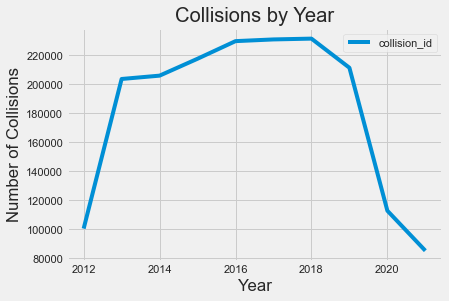

In [137]:
def plot_collisions_by_year(data):
    data['year'] = data['year'].astype(int)
    p = data.groupby('year').agg({'collision_id': len}).sort_values(by='year', ascending=False)
    p.plot()
    plt.title('Collisions by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Collisions')
    # plt.xlim(2021, 2012)
    return plt.plot()
plot_collisions_by_year(collision_df)

The year with the most collisions is 2018. 

# Data Quality

Working with this data we know there are some data quality issues. For example, the geolocation information. If you look at the Tableau Dashboard you will notice an issue with how the zip-codes are plotting on the map. The reason why this is occuring is because we typically take the **AVG()** of all data points within the latitude and longitude vectors. If we have a value with 0.0, it will negatively pull down the average from the rest of the vector. 

We should replace this latitude and longitude data with NaN / Null, when it is equal to 0.0. We can replace or do this when we pivot / group the data. 

In [17]:
collision_df.loc[:, ['latitude', 'longitude']].describe()

,latitude,longitude
count,1.615792e+06,1.615792e+06
mean,4.067283e+01,-7.383508e+01
std,1.447575e+00,2.823822e+00
min,0.000000e+00,-2.013600e+02
25%,4.066845e+01,-7.397563e+01
50%,4.072168e+01,-7.392805e+01
75%,4.076903e+01,-7.386668e+01
max,4.334444e+01,0.000000e+00


Latitude (0.0) the min - is a data quality issue. This is wrong because the location of (0.0, 0.0) is known as Null Island, this is where the Prime meridian and the equator intersect. 

In [24]:
# Confirm first - Finding the number of issues and a few IDs for 0.0 Latitude
len(collision_df[collision_df['latitude'] == 0.0]['collision_id']), collision_df[collision_df['latitude'] == 0.0]['collision_id'].head()

(2038,
 785785    3421906
 785806    3421927
 813121    3449248
 816864    3452991
 816865    3452992
 Name: collision_id, dtype: int64)

There are about 2,038 records with a latitude of 0.0 - I expect the longitude data to be the same IDs. As we can see below, the location field is a dictionary of lat/long, and when the latitude is 0.0 the longitude is 0.0. This is a data quality issue.

In [30]:
# filtering on a given collision ID to find 
collision_df[collision_df['collision_id'].isin([3452992, 3452991]) ]['location']

816864    {'latitude': '0.0', 'longitude': '0.0'}
816865    {'latitude': '0.0', 'longitude': '0.0'}
Name: location, dtype: object

# Next Steps

This is a very brief introduction into the Motor Vehicle Crash Collision dataset. If we were to extend this project to incorporate more data and to address the data quality, we should inspect the two MVC tables that share a relationship - Vehicles and Persons. 

The next steps would be to further clean-up the dataset, by enriching the underlying data with publically available data and other python related libraries. For example, we pulled a list of all the zip_codes and boroughs in NYC from a website. We used a popular library to parse html called `BeautifulSoup`. From this, we would be to create a function to pull the zipcode from the latitude and longtitude coordinates. The number of missing locations is much lower than the number of boroughs and zip codes. We can use the `geopy` or `pgeocode` library. 

In [30]:
def get_zip_code_data(zip_code, country_code='us'):
    # can query one or many
    nomi = pgeocode.Nominatim(country_code)
    nomi_zipcode_data = nomi.query_postal_code(zip_code)
    return nomi_zipcode_data

def get_geo_data():
    zip_codes = get_zip_codes()
    unique_zips = list(set(zip_codes['zip_code']))

    zip_data = get_zip_code_data(unique_zips)
    return zip_data
    
geo_df = get_geo_data()

In [153]:
enriched_data = pd.merge(collision_df, geo_df, left_on='zip_code', right_on='postal_code', how='left')

In [172]:
enriched_data.shape

(1830092, 49)

Our enriched data now contains 1830092 rows and 49 columns!

In [ ]:
# Get all the zip codes from our dataframe
# TODO: Update collision_df to fix the zip_code field from '10014.0' to 10014; string to integer
all_collision_zips = set()
for val in collision_df['zip_code']:
    try:
        if np.float_(val):
            all_collision_zips.add(np.int_(val))
    except Exception as err:
        all_collision_zips.add(np.nan)
all_collision_zips = list(all_collision_zips)

# Conclusion

There is a lot of questions we can ask ourselves from this dataset!

In this notebook we were able to explore the dataset, while answering Mikes questions using Python and Tableau. We have successfully optimized the API call, created an async_api.py file for testing the asynchronous programming and created a unit test for the API Response (located in tests folder). 

I hope this notebook provides a general introduction into my code style and technical abilities. Also demonstrating the capability to solve problems / answer questions using different technologies and libraries. We did not get the chance to showcase `pydatatable`, if you want to look more into the package this doc [compares `pandas` to `datatable`](https://datatable.readthedocs.io/en/latest/manual/comparison_with_pandas.html), using code. 

Look forward to hearing back from the team!

Best,
Jordan Carson